# Municipality Analysis

In [1]:
#Cargando librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import reverse_geocoder as rg 
import pprint 

In [2]:
df = pd.read_csv('co_properties.csv')
df.drop(df[(df['lon'].isna()) & (df['lat'].isna()) & (df["l3"].isna())].index, inplace=True)

## Utility Functions

In [3]:
# Dataframe must have been given reset_indexed
# Complete missing values where deparment and municipality are unknown
def relocate(df_geo):
    n = df_geo.shape[0]
    for i in range(0,n):
        lat = df_geo.loc[i, 'lat']
        lon = df_geo.loc[i, 'lon']
        if(~np.isnan(lat) and ~np.isnan(lon)):
            df_geo.loc[i, 'l2'], df_geo.loc[i, 'l3'] = reverseGeocode((lat,lon))
            
    return df_geo

#Calculates missing data and shows dataframe
def calculate_missing(df):
    s_types = df.dtypes
    missing = df.isnull().sum()
    missing_per = (df.isnull().sum()/df.shape[0])*100

    explo = pd.DataFrame({'Type' : s_types, 'Missing' : missing,
                       'Missing%' : missing_per}).sort_values(by=['Missing%', 'Type'], ascending=False)

    return explo

#Graph missing data given dataframe
def graph_missing(df):

    df_missing = calculate_missing(df)

    df_missing = df_missing.where(df_missing['Missing%'] > 25).dropna(subset=['Missing%'])

    sns.barplot(x=df_missing.index, y=df_missing['Missing%'], data=df_missing)

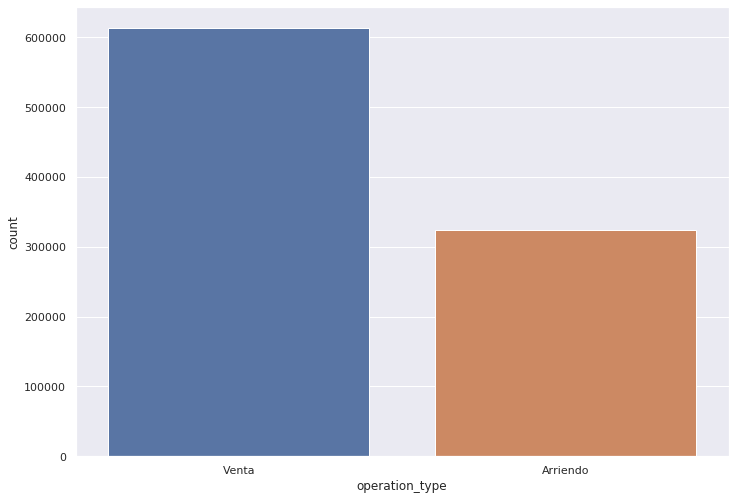

In [4]:
sns.set(rc={'figure.figsize':(11.7,8.27)})     
df = df.where(df['operation_type'] != 'Arriendo temporal')
sns.countplot(data = df, x = 'operation_type')

In [5]:
df_sell = df.where(df['operation_type'] == 'Venta').dropna(subset=['operation_type'])
df_rent = df.where(df['operation_type'] == 'Arriendo').dropna(subset=['operation_type'])

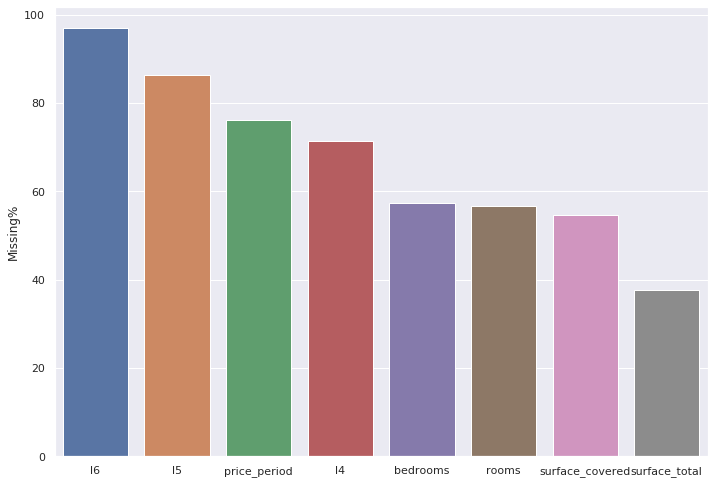

In [6]:
graph_missing(df_sell)

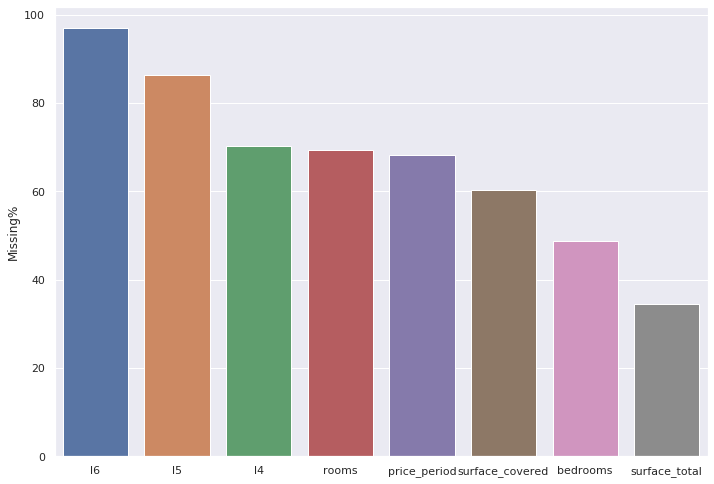

In [7]:
graph_missing(df_rent)

In [8]:
df_rent.drop(columns=['l6', 'l5', 'l4', 'rooms', 'price_period', 'surface_covered'], inplace=True)
df_sell.drop(columns=['l6', 'l5', 'l4', 'rooms', 'price_period', 'surface_covered'], inplace=True)

In [9]:
df_medellin = df_sell.where(df_sell['l3'] == 'Medellín').dropna(subset=['l3'])

def new_features(df):
    df_features = df.copy()
    df_features = df_features[df_features["end_date"].str.contains('9999')==False]
    df_features['price_m2'] = df['price'] / df['surface_total']
    df_features['end_date'] = pd.to_datetime(df_features.end_date)
    df_features['created_on'] = pd.to_datetime(df_features.created_on)
    df_features['delta_time'] = df_features['end_date'] - df_features['created_on'] 
    df_features['delta_time'] = df_features['delta_time'].dt.days

    return df_features
    
df_medellin = df_medellin[df_medellin['price']<df_medellin['price'].quantile(0.98)]
df_medellin = df_medellin[df_medellin['price'] > df_medellin['price'].quantile(0.2)]
df_medellin = df_medellin[df_medellin['surface_total'] > 0]

df_medellin = new_features(df_medellin)

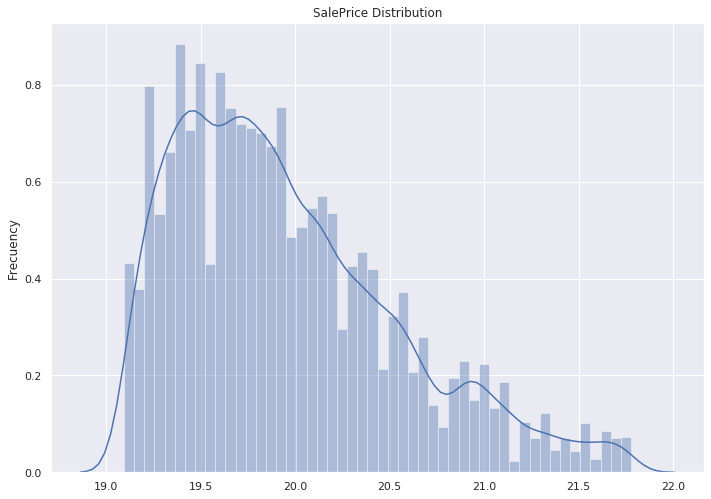

In [10]:
ax = sns.distplot(np.log(df_medellin['price']));
ax.set(xlabel='', ylabel='Frecuency',title ="SalePrice Distribution")
plt.show()

In [29]:
df_medellin = df_medellin.drop(columns=['id', 'ad_type', 'start_date', 'end_date', 'created_on',
                          'l1', 'l2', 'l3', 'currency', 'title', 'description', 'operation_type'])

## Machine Learning

In [32]:
X_df = df_medellin.drop('price', axis=1).copy()
Y_df = df_medellin['price'].copy()

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
X_train_or, X_test_or, Y_train_or, Y_test_or = train_test_split(X_df, Y_df, 
                                                    test_size=0.2, 
                                                    random_state=2)

In [35]:
# Para eliminar SettingWithCopyWarning
X_train = X_train_or.copy()
X_test = X_test_or.copy()
Y_train = Y_train_or.copy()
Y_test = Y_test_or.copy()

In [36]:
from sklearn.preprocessing import (PowerTransformer, StandardScaler, 
                                   MinMaxScaler, LabelEncoder, OneHotEncoder)

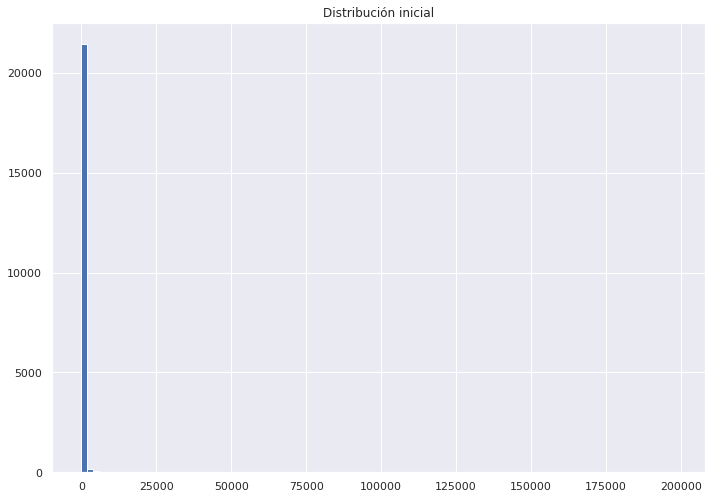

In [37]:
# Validar que todos los valores sean mayores a 0 para poder realizar la transformación.
(X_train["surface_total"]>0).sum() == len(X_train)
X_train["surface_total"].hist(bins=100)
plt.title("Distribución inicial")
plt.show()

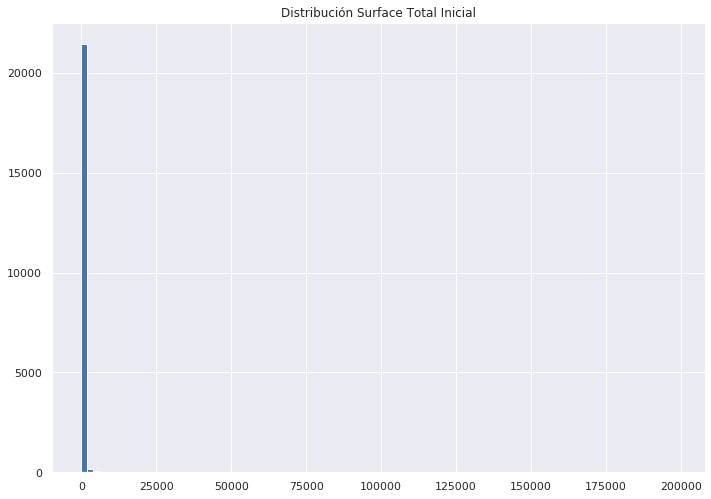

In [38]:
X_train['surface_total'] .hist(bins=100)
plt.title('Distribución Surface Total Inicial')
plt.show()

In [39]:
box_cox = PowerTransformer(method='box-cox') # Crea la instancia del objeto Box-Cox
box_cox.fit(X_train["surface_total"].values.reshape(-1,1)) # Se realiza el fit de Box-Cox. Tiene que ser un array de 2 dimensiones la entrada
X_train.loc[:,"surface_total"] = box_cox.transform(X_train["surface_total"].values.reshape(-1,1)) # Transformamos el array
X_train.head()

,lat,lon,bedrooms,bathrooms,surface_total,property_type,price_m2,delta_time
631977,6.240304,-75.593316,NaN,4.0,0.668608,Apartamento,4.000000e+06,96
682945,6.244705,-75.601334,4.0,3.0,-0.136079,Casa,2.410714e+06,64
797069,6.253000,-75.565002,3.0,2.0,-0.663838,Apartamento,2.530120e+06,83
404078,6.207000,-75.601997,3.0,2.0,-1.119274,Apartamento,3.030303e+06,78
699881,6.208949,-75.591946,NaN,2.0,-1.057209,Apartamento,3.088235e+06,106


In [40]:
box_cox.lambdas_ # Lambdas aprendidos

array([-0.4577873])

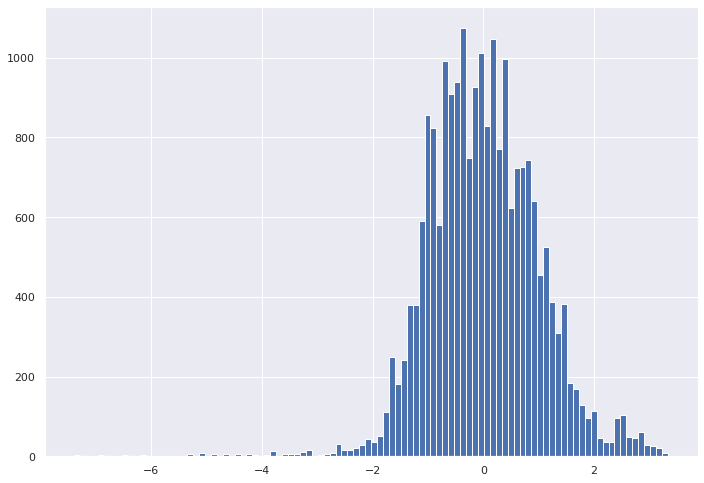

In [41]:
# Visualización de distribución
X_train["surface_total"].hist(bins=100)
plt.show()
# Se aproxima en gran medida a una distribución normal visualmente
# Nótese que los datos están centrados en 0 y pareciera que tiene desviación unitaria.
# Al interior de Power Transformer se hace un Standard Scaler

### Standard Scaler
El Standard Scaler sirve para centrar una distribución en 0 y que tenga desviación estándar unitaria.

 $$\mathbf{Z} = \frac{\mathbf{X} - \mathbf{\mu}}{\mathbf{\sigma}}$$


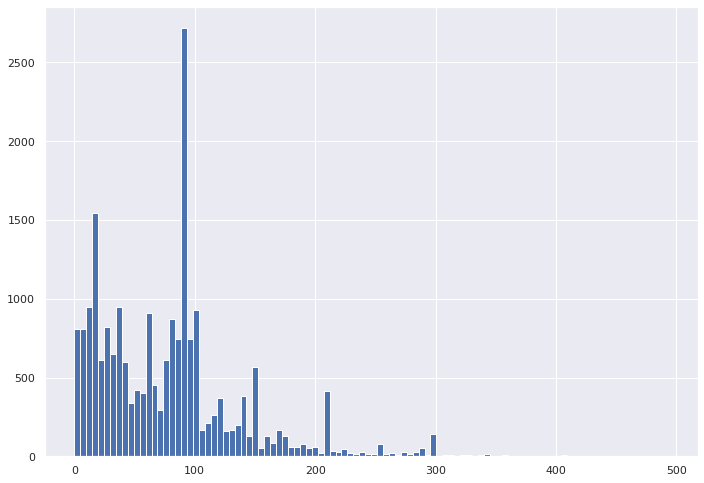

In [42]:
X_train['delta_time'].hist(bins=100)
plt.show()

In [43]:
sc_delta = StandardScaler()
sc_delta.fit(X_train.loc[:,'delta_time'].values.reshape(-1,1))
X_train.loc[:,'delta_time'] = sc_delta.transform(X_train['delta_time'].values.reshape(-1,1))

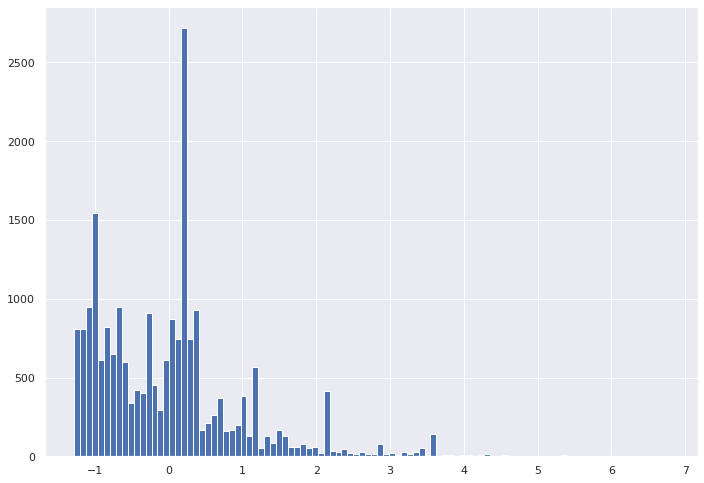

In [44]:
X_train['delta_time'].hist(bins=100)
plt.show()

In [45]:
print("Classes: ", X_train['property_type'].unique()) # Clases categoricas
X_train.head()

Classes:  ['Apartamento' 'Casa' 'Otro' 'Lote' 'Local comercial' 'Oficina' 'Finca'
 'Depósito' 'Parqueadero']


,lat,lon,bedrooms,bathrooms,surface_total,property_type,price_m2,delta_time
631977,6.240304,-75.593316,NaN,4.0,0.668608,Apartamento,4.000000e+06,0.288139
682945,6.244705,-75.601334,4.0,3.0,-0.136079,Casa,2.410714e+06,-0.233980
797069,6.253000,-75.565002,3.0,2.0,-0.663838,Apartamento,2.530120e+06,0.076028
404078,6.207000,-75.601997,3.0,2.0,-1.119274,Apartamento,3.030303e+06,-0.005553
699881,6.208949,-75.591946,NaN,2.0,-1.057209,Apartamento,3.088235e+06,0.451301


In [51]:
le_proper_type = LabelEncoder()
le_proper_type.fit(X_train['property_type'])
X_train['property_type'] = le_proper_type.transform(X_train['property_type'])

In [53]:
ohe_proper_type = OneHotEncoder()
ohe_proper_type.fit(X_train["property_type"].values[:,None])
# OHE transform retorna una matriz tipo sparse, por su velocidad en computacion y memoria requerida.
out = ohe_proper_type.transform(X_train["property_type"].values[:,None]) 
out_array = out.toarray()
ohe_cols_op = []
for category in ohe_proper_type.categories_[0]:
    current_class = le_proper_type.classes_[int(category)]
    col_add = "op_" + current_class
    ohe_cols_op.append(col_add)
    X_train[col_add] = out_array[:,int(category)]

X_train = X_train.drop("property_type", axis =1)

In [54]:
X_train.head()

,lat,lon,bedrooms,bathrooms,surface_total,price_m2,delta_time,op_Apartamento,op_Casa,op_Depósito,op_Finca,op_Local comercial,op_Lote,op_Oficina,op_Otro,op_Parqueadero
631977,6.240304,-75.593316,NaN,4.0,0.668608,4.000000e+06,0.288139,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
682945,6.244705,-75.601334,4.0,3.0,-0.136079,2.410714e+06,-0.233980,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
797069,6.253000,-75.565002,3.0,2.0,-0.663838,2.530120e+06,0.076028,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
404078,6.207000,-75.601997,3.0,2.0,-1.119274,3.030303e+06,-0.005553,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
699881,6.208949,-75.591946,NaN,2.0,-1.057209,3.088235e+06,0.451301,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Tratamiento de datos faltantes o NaN
Para tratar con datos nulos o faltantes, scikit learn tiene una familia de Imputadores ([SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn.impute.SimpleImputer), [IterativeImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn.impute.IterativeImputer) y [MissingIndicator](https://scikit-learn.org/stable/modules/generated/sklearn.impute.MissingIndicator.html#sklearn.impute.MissingIndicator)). En este caso vamos a usar el Simple Imputer.

In [55]:
from sklearn.impute import SimpleImputer
# Mirando que columnas tienen NaNs
X_train.isnull().sum()

lat                   5402
lon                   5402
bedrooms              5567
bathrooms              780
surface_total            0
price_m2                 0
delta_time               0
op_Apartamento           0
op_Casa                  0
op_Depósito              0
op_Finca                 0
op_Local comercial       0
op_Lote                  0
op_Oficina               0
op_Otro                  0
op_Parqueadero           0
dtype: int64

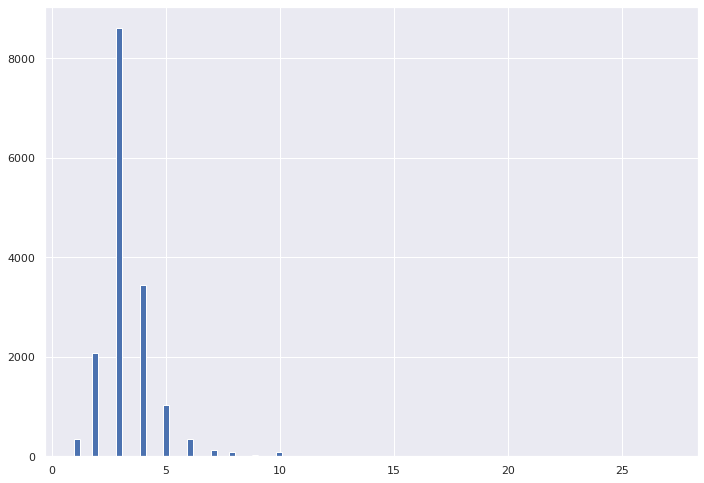

In [57]:
X_train["bedrooms"].hist(bins=100)
plt.show()

In [60]:
si_bedrooms = SimpleImputer(strategy='median')
si_bedrooms.fit(X_train["bedrooms"].values[:,None])
X_train["bedrooms"] = si_bedrooms.transform(X_train["bedrooms"].values[:,None])

In [61]:
X_train.isnull().sum()

lat                   5402
lon                   5402
bedrooms                 0
bathrooms              780
surface_total            0
price_m2                 0
delta_time               0
op_Apartamento           0
op_Casa                  0
op_Depósito              0
op_Finca                 0
op_Local comercial       0
op_Lote                  0
op_Oficina               0
op_Otro                  0
op_Parqueadero           0
dtype: int64

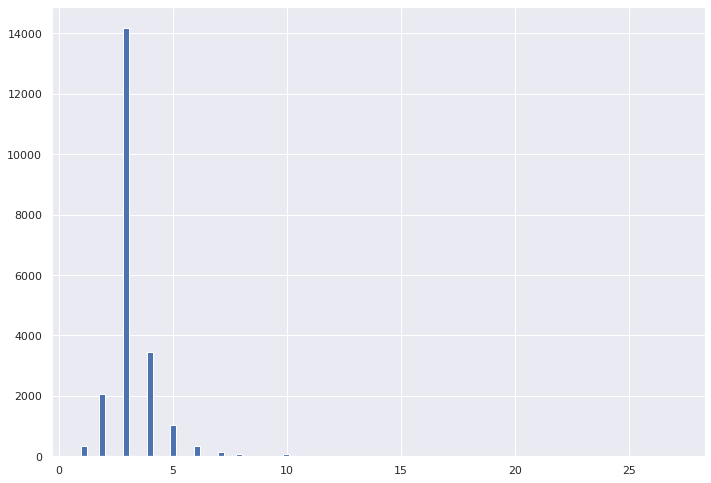

In [62]:
X_train["bedrooms"].hist(bins=100)
plt.show()